So - this Notebook is local, but it's kernel is remote (on Paperspace). I don't think there's a way to open remote notebooks here, or maybe there is.

But this is better since I can check the notebook into source control.

Have to be careful about where data is stored though.

In [ ]:
%pip install numpy==1.21.1 Pillow==9.0.1 matplotlib==3.5.1 tqdm==4.62.3

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pathlib
import os

%cd /notebooks
!git clone https://github.com/idealo/image-super-resolution
!git checkout 3f6498cf1ac4dba162a52c5861aa9d90b7c2fe35
%cd image-super-resolution
!python setup.py install
root = pathlib.Path('/notebooks/image-super-resolution')

/notebooks
fatal: destination path 'image-super-resolution' already exists and is not an empty directory.
fatal: reference is not a tree: 3f6498cf1ac4dba162a52c5861aa9d90b7c2fe35
/notebooks/image-super-resolution
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:717: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
running install
running bdist_egg
running egg_info
writing ISR.egg-info/PKG-INFO
writing dependency_links to ISR.egg-info/dependency_links.txt
writing requirements to ISR.egg-info/requires.txt
writing top-level names to ISR.egg-info/top_level.txt
reading manifest file 'ISR.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'ISR.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ISR
cop

# Ensure it works by running inference

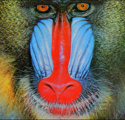

In [35]:
import numpy as np
from PIL import Image

img = Image.open(root / 'data/input/sample/baboon.png')
lr_img = np.array(img)
img

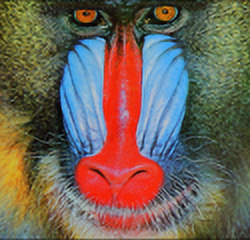

In [36]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')
sr_img = rdn.predict(lr_img)
Image.fromarray(sr_img)

17473536/17462488 [==============================] - 2s 0us/step


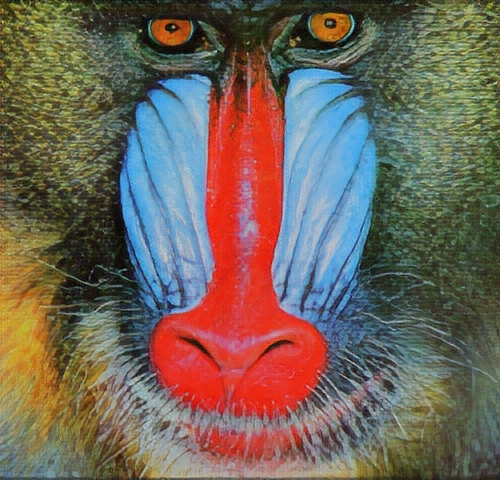

In [59]:
from ISR.models import RRDN

rrdn = RRDN(weights='gans')
sr_img = rrdn.predict(lr_img)
Image.fromarray(sr_img)

# Dataset

Prepare the dataset. We use images from [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/).

Specifically, we're using:

- Train Data (HR Images): High Res Training Data
- Validation Data (HR Images): High Res Validation Data
- Train Data Track 2 realistic mild (LR Images): Low Res Training Data
- Validation Data Track 2 realistic mild (LR Images): Low Res Validation Data

In [112]:
hr_train_dir='data/DIV2K_train_HR'
hr_valid_dir='data/DIV2K_valid_HR'
lr_train_dir='data/DIV2K_train_LR_mild'
lr_valid_dir='data/DIV2K_valid_LR_mild'

In [113]:
import random
from PIL import Image 
import matplotlib as mpl
import matplotlib.pyplot as plt

def my_hook(t):
    """Wraps tqdm instance.
    Don't forget to close() or __exit__()
    the tqdm instance once you're done with it (easiest using `with` syntax).
    Example
    -------
    >>> with tqdm(...) as t:
    ...     reporthook = my_hook(t)
    ...     urllib.urlretrieve(..., reporthook=reporthook)
    """
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return update_to

def show_images(folder, n=16):
    images = []
    for image in list(os.listdir(folder)):
        images.append(os.path.join(folder, image))

    plt.figure(1, figsize=(15, 9))
    # plt.axis('off')
    i = 0
    for _ in range(16):
        i += 1
        random_img = random.choice(images)
        imgs = plt.imread(random_img)
        plt.subplot(4, 4, i)
        # plt.axis('off')
        plt.imshow(imgs)

    plt.show()

http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip data/DIV2K_train_HR
data/DIV2K_train_HR


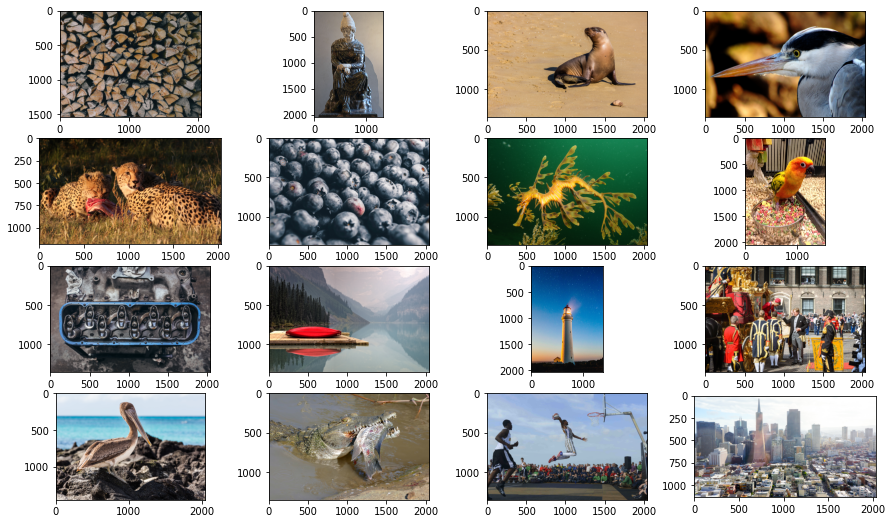

http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip data/DIV2K_valid_HR
data/DIV2K_valid_HR


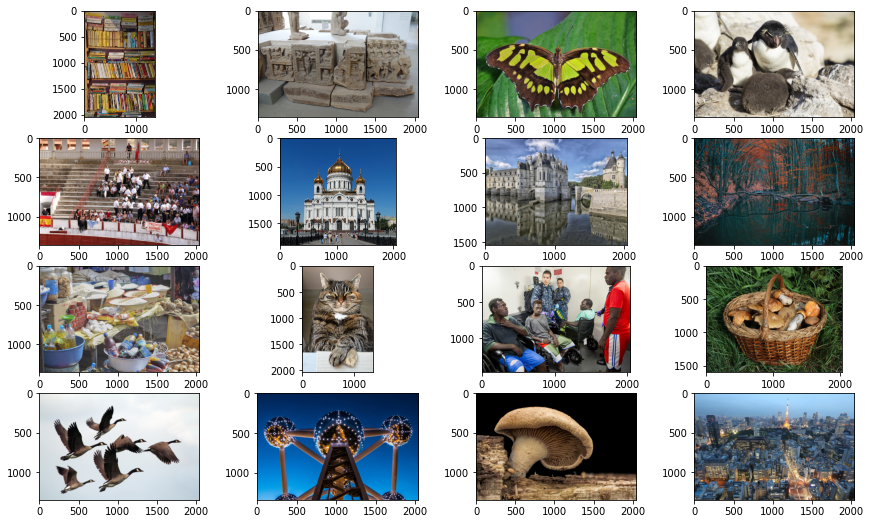

http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_mild.zip data/DIV2K_train_LR_mild
data/DIV2K_train_LR_mild


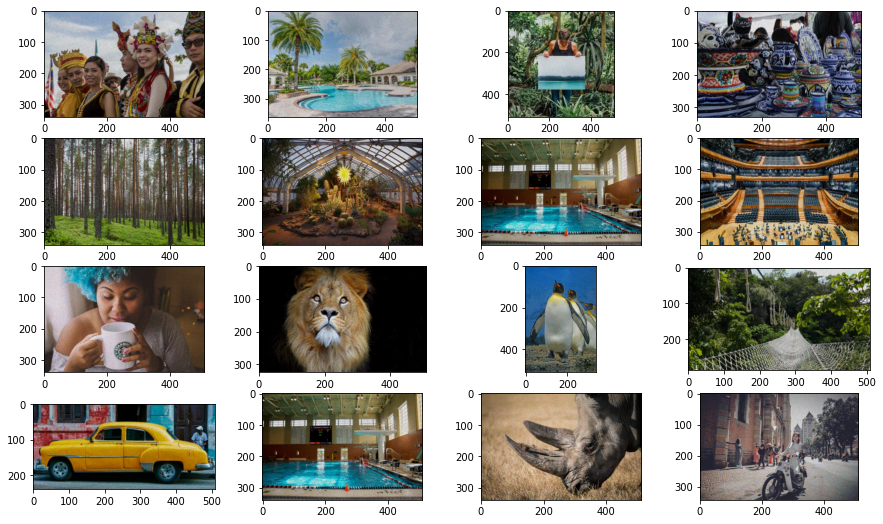

http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_mild.zip data/DIV2K_valid_LR_mild
data/DIV2K_valid_LR_mild


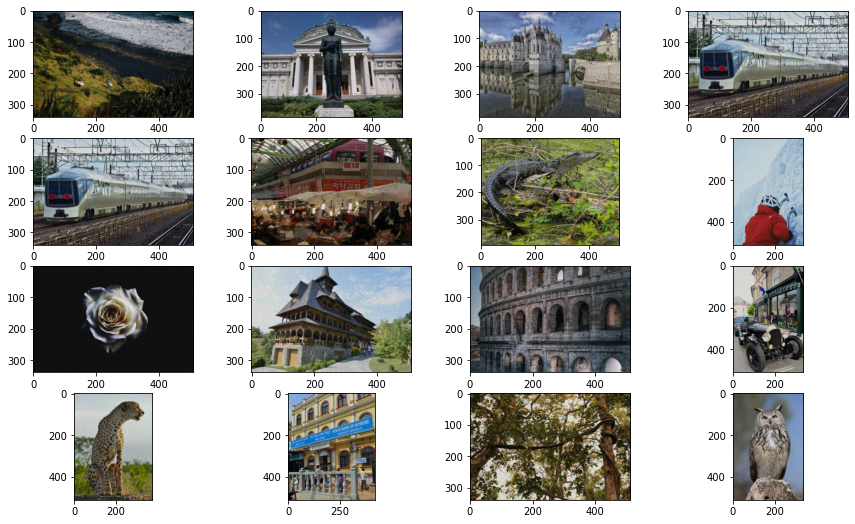

In [117]:
import os
import urllib.request
from tqdm import tqdm
import zipfile

TMP = pathlib.Path(root / 'tmp')
TMP.mkdir(exist_ok=True, parents=True)
pathlib.Path(root / 'data').mkdir(exist_ok=True, parents=True)

def wget(url, filename_path):
    dirpath = os.path.dirname(filename_path)
    pathlib.Path(dirpath).mkdir(exist_ok=True, parents=True)
    filename = url.split('/')[-1]
    with tqdm(unit = 'B', unit_scale = True, unit_divisor = 1024, miniters = 1, desc = filename) as t:
        print(f'Downloading url {url}')
        urllib.request.urlretrieve(url, filename = filename_path, reporthook = my_hook(t), data = None)

def download(url, target, data_dir, should_show_images=True):
    if not os.path.isdir(target):
        # download target
        target_filepath = TMP / f'{target}.zip'
        if not os.path.isfile(target_filepath):
            wget(url, target_filepath)

        with zipfile.ZipFile(target_filepath, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            os.remove(target_filepath)

    if should_show_images:
        print(target)
        show_images(target)
        


for url, folder in [
    ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', hr_train_dir],
    ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip', hr_valid_dir],
    ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_mild.zip', lr_train_dir],
    ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_mild.zip', lr_valid_dir],
]:
    download(url, folder, 'data')

# Training

In [127]:
from train import train_rdn
train_rdn(lr_train_dir, lr_valid_dir, hr_train_dir, hr_valid_dir)

CHANGELOG		 ISR	       data	  low_res    setup.py
CONTRIBUTING.md		 ISR.egg-info  dist	  mkdocs     tests
DIV2K_train_HR.zip	 LICENSE       figures	  notebooks  tmp
DIV2K_valid_LR_mild.zip  README.md     high_res   pypi.sh    weights
Dockerfile.cpu		 build	       high_rest  scripts
Dockerfile.gpu		 config.yml    log_file   setup.cfg


/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(

Training details:
  training_parameters: 
    lr_train_dir: data/DIV2K_train_LR_mild
    hr_train_dir: data/DIV2K_train_HR
    lr_valid_dir: data/DIV2K_valid_LR_mild
    hr_valid_dir: data/DIV2K_valid_HR
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    log_dirs: {'logs': './logs', 'weights': './weights'}
    fallback_save_every_n_epochs: 2
    dataname: image_dataset
    n_validation: 40
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    metrics: {'generator': <function PSNR_Y at 0x7f3